In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
import plotly.figure_factory as ff


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Nursing Home Provider Info
df = pd.read_csv('./NH_ProviderInfo_Jul2021.csv', encoding='mac-roman')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15298 entries, 0 to 15297
Data columns (total 88 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Federal Provider Number                                          15298 non-null  object 
 1   Provider Name                                                    15298 non-null  object 
 2   Provider Address                                                 15298 non-null  object 
 3   Provider City                                                    15298 non-null  object 
 4   Provider State                                                   15298 non-null  object 
 5   Provider Zip Code                                                15298 non-null  int64  
 6   Provider Phone Number                                            15298 non-null  int64  
 7   Provider SSA County Code                

# The Number of Revisits in each Rating Cycle, Nursing Homes who have had a Recent Health Inspection, and Average Number of Nursing Homes that have each Rating 

pandas.core.frame.DataFrame

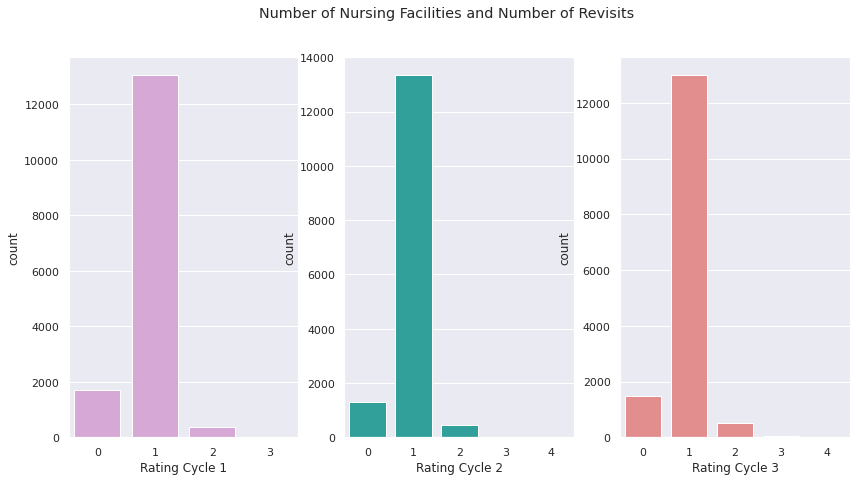

In [ ]:
revisits = pd.concat([df['Provider Name'],df['Rating Cycle 1 Number of Health Revisits'],df['Rating Cycle 2 Number of Health Revisits'],df['Rating Cycle 3 Number of Health Revisits']],axis=1,keys=['Provider','Rating Cycle 1','Rating Cycle 2','Rating Cycle 3'])
revisits.drop(revisits.index[revisits['Rating Cycle 1'] == '.'], inplace=True)
revisits.drop(revisits.index[revisits['Rating Cycle 2'] == '.'], inplace=True)
revisits.drop(revisits.index[revisits['Rating Cycle 3'] == '.'], inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14,7))

sns.countplot(data = revisits, x = 'Rating Cycle 1',order=['0','1','2','3'],color='plum',ax=ax[0])
sns.countplot(data = revisits, x = 'Rating Cycle 2',order=['0','1','2','3','4'],color='lightseagreen',ax=ax[1])
sns.countplot(data = revisits, x = 'Rating Cycle 3',order=['0','1','2','3','4'],color='lightcoral',ax=ax[2])
plt.suptitle('Number of Nursing Facilities and Number of Revisits')
fig.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


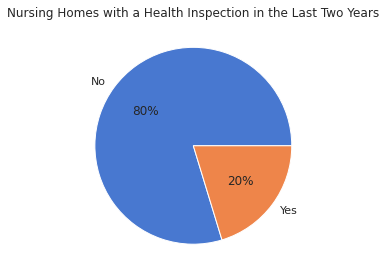

In [ ]:
options = ['No','Yes']
recent_inspection = pd.concat([df['Provider Name'],df['Most Recent Health Inspection More Than 2 Years Ago']],axis=1,keys=['Provider','In Last 2 Years?'])
recent_inspection = recent_inspection.groupby('In Last 2 Years?')['In Last 2 Years?'].count()
recent_inspection = recent_inspection.to_frame()
recent_inspection.head()

colors = sns.color_palette('muted')[0:5]

#create pie chart
plt.pie(recent_inspection, labels = options, colors = colors, autopct='%.0f%%')
plt.title('Nursing Homes with a Health Inspection in the Last Two Years')
plt.tight_layout()
plt.show()

Average Percentage of Nursing Homes in Each Rating Category


In [ ]:
import statistics 
cycles = ['Rating Cycle 1', 'Rating Cycle 2', 'Rating Cycle 3']
new = {}
for j in range(5):
  div=[]

  for i in cycles:
    testt = revisits.groupby(i)[i].count()
    div.append(testt[j]/testt.sum()) #percent

  divmean = statistics.mean(div) #average percent
  inputs = str(j)+' Revisits'
  outputs = str(round((divmean*100),2))+'%'
  new[inputs]= outputs
percentage = pd.Series(data=new, index=['0 Revisits', '1 Revisits', '2 Revisits','3 Revisits','4 Revisits'])
percentage = percentage.to_frame()
percentage.columns = ["Percentage"]
percentage

,Percentage
0 Revisits,1.18%
1 Revisits,9.78%
2 Revisits,85.89%
3 Revisits,2.96%
4 Revisits,0.17%


# Data Analysis and Machine Learning on predicting Nursing Homes' Overall Rating:

Data Cleaning

In [ ]:
#removing not needed columns
remove = ['Average Number of Residents per Day','Automatic Sprinkler Systems in All Required Areas','RN Staffing Rating Footnote','Average Number of Residents per Day Footnote','Federal Provider Number','Provider Name','Provider Address','Provider City','Provider State','Provider Zip Code','Provider Phone Number','Provider SSA County Code','Provider County Name','Provider Type','Legal Business Name','Date First Approved to Provide Medicare and Medicaid Services','Overall Rating Footnote','Health Inspection Rating Footnote','QM Rating Footnote','Long-Stay QM Rating Footnote','Short-Stay QM Rating Footnote','Staffing Rating Footnote','Reported Staffing Footnote','Physical Therapist Staffing Footnote','Rating Cycle 1 Standard Survey Health Date','Rating Cycle 2 Standard Health Survey Date','Rating Cycle 3 Standard Health Survey Date','Location','Processing Date']
new_df = df.drop(columns=remove)

#replacing nan values
new_df['Special Focus Status'].fillna(value='N',inplace=True)
new_df.dropna(inplace=True)

rating_cycle_cols = list(filter(lambda x: x.startswith('Rating Cycle') and not x.endswith('Date'), df.columns))
rating_cols = [col for col in new_df.columns if 'Rating Cycle' in col]
for i in rating_cols:
  new_df = new_df[new_df[i] != '.']
  new_df[i]=new_df[i].astype(str).astype(int)

# convert "." to NaN
for col in rating_cycle_cols:
  df.at[df[col].apply(lambda x: not str(x).isnumeric()), col] = np.nan
  df[col] = df[col].astype(float)
display(df.info())


ValueError: ignored

Permutation Importance and Random Forest Regression

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


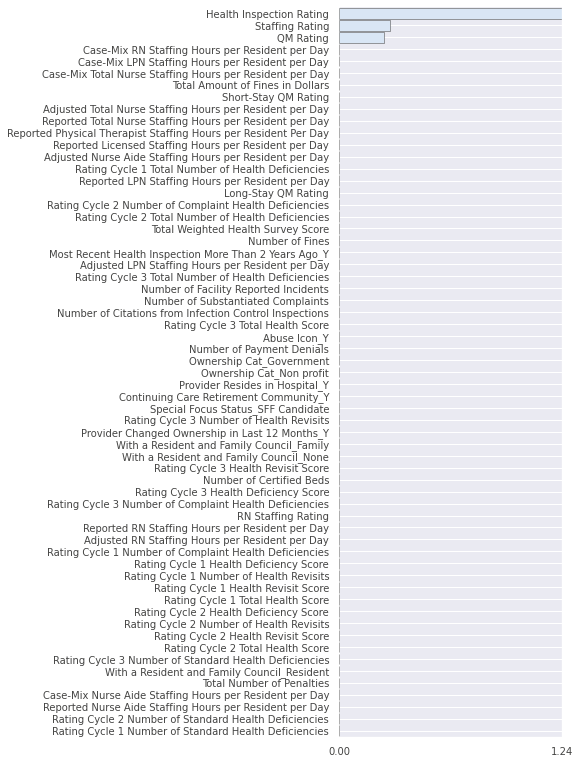

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble._forest import _generate_unsampled_indices
from distutils.version import LooseVersion
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
import tempfile
from os import getpid

#creating dummy variables to replace Y/N values
new_df = pd.get_dummies(new_df, columns=['Ownership Cat','Provider Resides in Hospital','Continuing Care Retirement Community','Special Focus Status','Abuse Icon','Most Recent Health Inspection More Than 2 Years Ago','Provider Changed Ownership in Last 12 Months','With a Resident and Family Council'], drop_first = True)

#creating the training data set
y = new_df['Overall Rating']
x_train = new_df.drop(columns='Overall Rating')

# Labels are the values we want to predict
labels = np.array(y)

features = np.array(x_train)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

# Instantiate Random Forest model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the Random Forest model on training data
rf.fit(train_features, train_labels);


def _get_unsampled_indices(tree, n_samples):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
        # Version 0.24 moved forest package name
        from sklearn.ensemble._forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    elif LooseVersion(sklearn.__version__) >= LooseVersion("0.22"):
        # Version 0.22 or newer uses 3 arguments.
        from sklearn.ensemble.forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    else:
        # Version 0.21 or older uses only two arguments.
        return _generate_unsampled_indices(tree.random_state, n_samples)


def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. 
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

 #calculate permutation importances for random forest regressor with oob R^2 as baseline.
imp = permutation_importances(rf, x_train, y,
                              oob_regression_r2_score)



#plot permutation importance

imp2 = pd.DataFrame(data={'Feature':x_train.columns, 'Importance':imp})
imp2 = imp2.set_index('Feature')
imp2 = imp2.sort_values('Importance', ascending=False)
GREY = '#444443'

class PimpViz:
    """
    For use with jupyter notebooks, plot_importances returns an instance
    of this class so we display SVG not PNG.
    """
    def __init__(self):
        tmp = tempfile.gettempdir()
        self.pngfilename = tmp+"/PimpViz_"+str(getpid())+".png"
        plt.tight_layout()
        plt.savefig(self.pngfilename, bbox_inches='tight', pad_inches=0)

    def _repr_svg_(self):
        with open(self.pngfilename, "r", encoding='UTF-8') as f:
            svg = f.read()
        plt.close()
        return svg

    def save(self, filename):
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    def view(self):
        plt.show()

    def close(self):
        plt.close()
        
def plot_importances(df_importances,
                     yrot=0,
                     label_fontsize=10,
                     width=4,
                     minheight=1.5,
                     vscale=1,
                     imp_range=(-.002, .15),
                     color='#D9E6F5',
                     bgcolor=None,  # seaborn uses '#F1F8FE'
                     xtick_precision=2,
                     title=None,
                     ax=None):
  I = df_importances
  unit = 1
  ypadding = .1


  imp = I.Importance.values
  mindrop = np.min(imp)
  maxdrop = np.max(imp)
  imp_padding = 0.002
  imp_range = (min(imp_range[0], mindrop - imp_padding), max(imp_range[1], maxdrop + imp_padding))

  barcounts = np.array([f.count('\n')+1 for f in I.index])
  N = np.sum(barcounts)
  ymax = N * unit + len(I.index) * ypadding + ypadding
  # print(f"barcounts {barcounts}, N={N}, ymax={ymax}")
  height = max(minheight, ymax * .2 * vscale)

  if ax is None:
      plt.close()
      fig, ax = plt.subplots(1,1,figsize=(width,height))
  ax.set_xlim(*imp_range)
  ax.set_ylim(0,ymax)
  ax.spines['top'].set_linewidth(.3)
  ax.spines['right'].set_linewidth(.3)
  ax.spines['left'].set_linewidth(.3)
  ax.spines['bottom'].set_linewidth(.3)
  if bgcolor:
      ax.set_facecolor(bgcolor)

  yloc = []
  y = barcounts[0]*unit / 2 + ypadding
  yloc.append(y)
  for i in range(1,len(barcounts)):
      wprev = barcounts[i-1]
      w = barcounts[i]
      y += (wprev + w)/2 * unit + ypadding
      yloc.append(y)
  yloc = np.array(yloc)
  ax.xaxis.set_major_formatter(FormatStrFormatter(f'%.{xtick_precision}f'))
  # too close to show both max and right edge?
  if maxdrop/imp_range[1] > 0.9 or maxdrop < 0.02:
      ax.set_xticks([0, imp_range[1]])
  else:
      ax.set_xticks([0, maxdrop, imp_range[1]])
  ax.tick_params(labelsize=label_fontsize, labelcolor=GREY)
  ax.invert_yaxis()  # labels read top-to-bottom
  if title:
      ax.set_title(title, fontsize=label_fontsize+1, fontname="Arial", color=GREY)

  barcontainer = ax.barh(y=yloc, width=imp,
                          height=barcounts*unit,
                          tick_label=I.index,
                          color=color, align='center')

  # Alter appearance of each bar
  for rect in barcontainer.patches:
          rect.set_linewidth(.5)
          rect.set_edgecolor(GREY)

  # rotate y-ticks
  if yrot is not None:
      ax.tick_params(labelrotation=yrot)

  return PimpViz()

viz = plot_importances(imp2)
viz.view()

In [ ]:
#Compare Random Forest Regressor performance using all features vs only the features with highest permutation importance
top_df = new_df[['Health Inspection Rating',
 'QM Rating',
 'Staffing Rating']]

features2 = np.array(top_df)
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels, test_size = 0.25, random_state = 42)

# Instantiate model with 1000 decision trees
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf2.fit(train_features2, train_labels2)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
print(rf.score(test_features,test_labels)) #all features
print(rf2.score(test_features2,test_labels2)) #top 3 features

0.9999758466924108
0.9999995471845998


Correlation Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


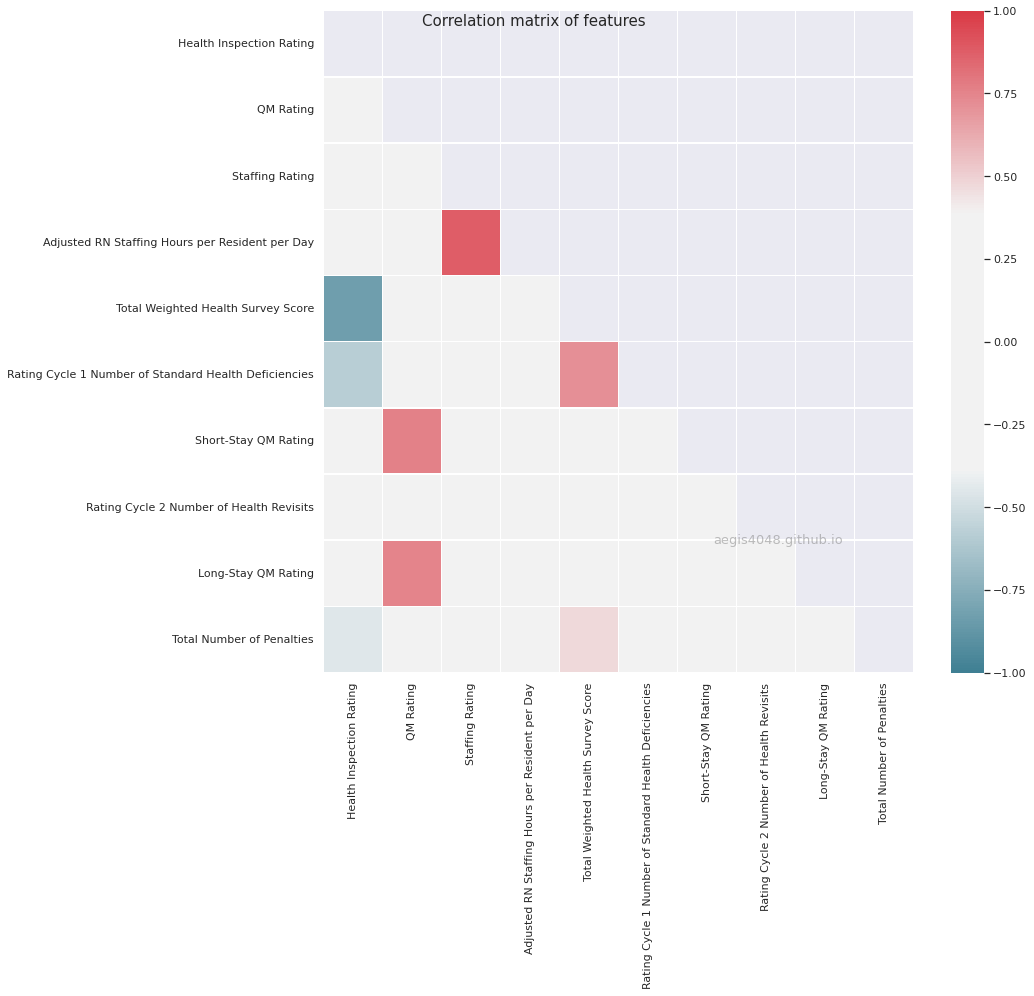

In [ ]:
#Find best features aka those that have a good p value

best_features = []

while (len(x_cols)>0):
    remaining_features = list(set(x_cols)-set(best_features))
    new_pval = pd.Series(index=x_cols)
    for new_column in remaining_features:
        model = sm.OLS(y, sm.add_constant(new_df[best_features+[new_column]])).fit()
        new_pval[new_column] = model.pvalues[new_column]
    min_p_value = new_pval.min()
    if(min_p_value<.001):
        best_features.append(new_pval.idxmin())
        while(len(best_features)>0):
            best_features_with_constant = sm.add_constant(new_df[best_features])
            p_values = sm.OLS(y, best_features_with_constant).fit().pvalues[1:]
            max_p_value = p_values.max()
            if(max_p_value >= 0.001):
                excluded_feature = p_values.idxmax()
                best_features.remove(excluded_feature)
            else:
                break 
    else:
        break

df3 = new_df[best_features]
best_features       

#Correlation Matrix for the best features:

corr = df3.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)
ax.text(0.77, 0.2, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()


Variance Inflation Factor

In [ ]:
#Variance Inflation Factor to assess multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = pd.DataFrame()
df3 = new_df[best_features]
VIF["feature"] = df3.columns

VIF['VIF']=[variance_inflation_factor(df3.values, i) for i in range(len(df3.columns))]

#Drop features with high VIF and recalculate VIF
df4 = VIF[VIF['VIF']<10]
xx=new_df[features2]
VIF2 = pd.DataFrame()
VIF2['feature'] = xx.columns
VIF2['VIF']=[variance_inflation_factor(xx.values, i)
                          for i in range(len(xx.columns))]
VIF2

,feature,VIF
0,Health Inspection Rating,4.799331
1,Adjusted RN Staffing Hours per Resident per Day,3.783830
2,Total Weighted Health Survey Score,4.500019
3,Rating Cycle 1 Number of Standard Health Defic...,3.823770
4,Rating Cycle 2 Number of Health Revisits,6.698894
5,Total Number of Penalties,1.867666


# Analyzing the correlation of Nursing Home Ownership Type and Overall Ratings and Ownership Statistics


In [ ]:
#Creating simpler ownership type column
keys = ['For profit','Non profit','Government']
for i in range(len(keys)):
  new_df.loc[new_df['Ownership Type'].str.contains(keys[i]), "Ownership Cat"] = keys[i]
  
new_df.drop(columns='Ownership Type',inplace=True)

for_profit = df[df['Ownership Type'].str.contains('For profit')]
nonprofit = df[df['Ownership Type'].str.contains('Non profit')]
government = df[df['Ownership Type'].str.contains('Government')]
  

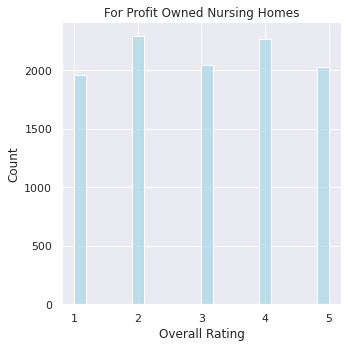

<Figure size 432x288 with 0 Axes>

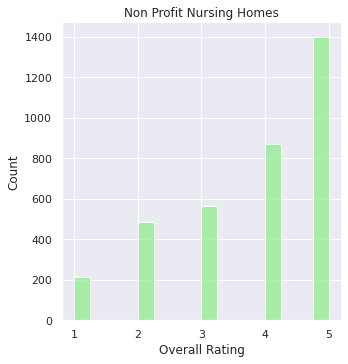

<Figure size 432x288 with 0 Axes>

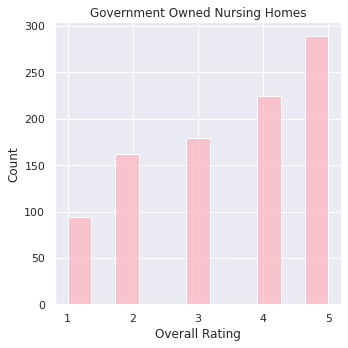

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.displot(data = for_profit, x = 'Overall Rating',kind='hist',color='lightblue').set(title='For Profit Owned Nursing Homes')
plt.tight_layout()
plt.show()
plt.clf()

sns.displot(data = nonprofit, x = 'Overall Rating',kind='hist',color='lightgreen').set(title='Non Profit Nursing Homes')
plt.show()
plt.tight_layout()
plt.clf()

sns.displot(data = government,x = 'Overall Rating',kind='hist',color='lightpink').set(title='Government Owned Nursing Homes')
plt.tight_layout()
plt.show()
plt.clf()


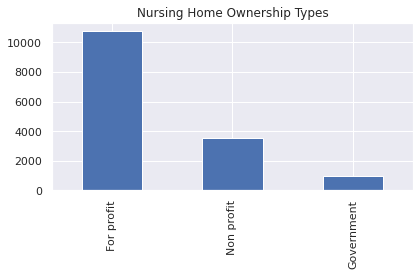

In [ ]:
df['Simple Ownership'] = ''
df['Simple Ownership'] = df['Ownership Type'].str.findall('|'.join(keys)).str[0]
df['Ownership Type']=df['Ownership Type'].astype('string')
df['Simple Ownership'].value_counts().plot(kind='bar').set(title='Nursing Home Ownership Types')
plt.tight_layout()


# Exploration of CA Nursing Homes

In [3]:
df_ca = df[df['Provider State'] == 'CA']
df_ca.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
617,055001,REDLANDS HEALTHCARE CENTER,1620 WEST FERN AVENUE,REDLANDS,CA,92373,9097932609,460,San Bernardino,For profit - Corporation,78,66.4,NaN,Medicare and Medicaid,N,ASH HOLDINGS LLC,1978-08-01,N,NaN,N,N,N,Both,Yes,4.0,NaN,3.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.35976,1.02328,0.43482,1.45810,3.81786,0.08525,2.15441,0.72102,0.35934,3.23478,2.25272,1.05694,0.49718,3.79134,2019-10-04,12,11,0,80,1,0,80,2018-10-05,8,7,1,48,1,0,48,2017-10-06,3,1,2,16,1,0,16,58.667,1,2,1.0,0,0,0,0,"1620 WEST FERN AVENUE,REDLANDS,CA,92373",2021-07-01
618,055002,COUNTRY MANOR HEALTHCARE,11723 FENTON AVENUE,LAKE VIEW TERRACE,CA,91342,8188990251,200,Los Angeles,For profit - Partnership,99,88.3,NaN,Medicare and Medicaid,N,"CANYON PROPERTIES III, LLC",1968-09-01,N,NaN,N,N,N,Both,Yes,5.0,NaN,3.0,NaN,5.0,NaN,5.0,NaN,NaN,2.0,4.0,NaN,4.0,NaN,NaN,NaN,2.53789,

In [4]:
county_fips = pd.read_csv('./state_and_county_fips_master.csv')
county_fips.head()

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL


In [5]:
county_fips_ca = county_fips[county_fips['state']=='CA'].copy()
county_fips_ca.loc[:,'name'] = county_fips_ca.loc[:,'name'].str.split('County').str[0]
county_fips_ca.name = county_fips_ca.name.str.rstrip()
county_fips_ca.drop(columns='state', inplace=True)
county_fips_ca.head()


,fips,name
192,6001,Alameda
193,6003,Alpine
194,6005,Amador
195,6007,Butte
196,6009,Calaveras


In [6]:
#Merge tables
new_ca = pd.merge(left=df_ca, right=county_fips_ca, left_on='Provider County Name', right_on='name')
new_ca.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date,fips,name
0,055001,REDLANDS HEALTHCARE CENTER,1620 WEST FERN AVENUE,REDLANDS,CA,92373,9097932609,460,San Bernardino,For profit - Corporation,78,66.4,NaN,Medicare and Medicaid,N,ASH HOLDINGS LLC,1978-08-01,N,NaN,N,N,N,Both,Yes,4.0,NaN,3.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.35976,1.02328,0.43482,1.45810,3.81786,0.08525,2.15441,0.72102,0.35934,3.23478,2.25272,1.05694,0.49718,3.79134,2019-10-04,12,11,0,80,1,0,80,2018-10-05,8,7,1,48,1,0,48,2017-10-06,3,1,2,16,1,0,16,58.667,1,2,1.0,0,0,0,0,"1620 WEST FERN AVENUE,REDLANDS,CA,92373",2021-07-01,6071,San Bernardino
1,055076,SPRING VALLEY POST ACUTE LLC,14973 HESPERIA ROAD,VICTORVILLE,CA,92392,7602456477,460,San Bernardino,For profit - Limited Liability company,126,92.1,NaN,Medicare and Medicaid,N,SPRING VALLEY POST ACUTE LLC,1971-02-19,N,NaN,N,Y,N,Resident,Yes,1.0,NaN,1.0,NaN,3.0,NaN,3.

Average Occupancy Rate of California Nursing Homes

In [7]:
new_ca['Occupancy Rate'] = (new_ca['Average Number of Residents per Day'] / new_ca['Number of Certified Beds'])*100
#new_ca.drop(columns = 'name',inplace=True)
ca_occ_mean = new_ca['Occupancy Rate'].mean()
ca_occ_mean

73.37017743684693

Analysis by County

In [8]:
#Calculate average occupancy rates for each county
by_county = new_ca.groupby('fips')['Occupancy Rate'].mean()
county_occ = by_county.to_frame()
county_occ['FIPS'] = county_occ.index

values = county_occ['Occupancy Rate'].tolist()
fips = county_occ['FIPS'].tolist()
endpts = list(np.mgrid[min(values):max(values):4j])

colorscale = ['#0A2F51','#0E4D64','#137177','#188977','#1D9A6C','#39A96B','#56B870','#74C67A','#99D492','#BFE1B0','#DEEDCF']
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=endpts, colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Average Occupancy Rate by County', title='California Nursing Home Occupancy Rates',
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)')
fig.layout.template = None
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_county_choropleth.py:361: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in fips_polygon_map[f]
/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_county_choropleth.py:365: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in fips_polygon_map[f]
/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_county_choropleth.py:368: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  x_c = [poly.centroid.xy[0].tolist() for poly in fips_polygon_map[f]]
/usr/l

Average Occupancy Rate of CA Nursing Homes by Nursing Home Size

In [ ]:
#Creating Size Column
new_ca.loc[new_ca['Number of Certified Beds']<50 , 'Size'] = '<50'
new_ca.loc[(new_ca['Number of Certified Beds']>=50) & (new_ca['Number of Certified Beds']<=99), 'Size'] = '50-99'
new_ca.loc[(new_ca['Number of Certified Beds']>=100) & (new_ca['Number of Certified Beds']<=149), 'Size'] = '100-149'
new_ca.loc[new_ca['Number of Certified Beds']>=150 , 'Size'] = '150+'


In [ ]:
grouped = new_ca.groupby('Size')['Occupancy Rate'].mean()
average_occ = grouped.to_frame()
average_occ = average_occ.reindex(index=average_occ.index[::-1])
average_occ['Size'] = average_occ.index
test

Size
100-149    73.298475
150+       70.722313
50-99      73.842912
<50        74.292596
Name: Occupancy Rate, dtype: float64

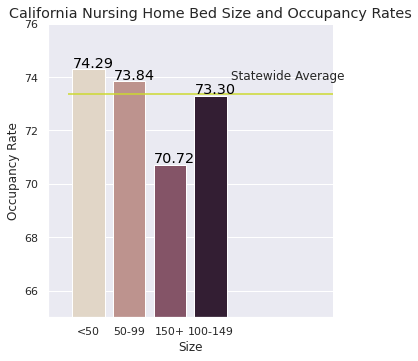

In [ ]:
#reordering last two size categories
temp = average_occ.iloc[-1]
average_occ.iloc[-1] = average_occ.iloc[-2]
average_occ.iloc[-2] = temp
average_occ_new = average_occ.rename(index={'150+': '100-149','100-149':'150+'})

graph = sns.catplot(x="Size", y='Occupancy Rate', kind="bar", palette="ch:.25", data=average_occ_new)
graph.fig.suptitle("California Nursing Home Bed Size and Occupancy Rates", x=0.6, y=1)
plt.ylim(65, 76)
plt.xlim(-1,6)
plt.hlines(ca_occ_mean, -0.5, 6, colors=(.8,.85,.186), linestyles='solid')

ax = graph.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.015, 
            p.get_height() * 1.001, 
            '{0:.2f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')
plt.text(3.5, 73.9, 'Statewide Average', fontdict=None)
plt.tight_layout()
